<a href="https://colab.research.google.com/github/kritduangprom/Krit_Portfolio/blob/main/Copy_of_ML2_coureswork_Bath_2023_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Age Estimation and Gender Classification

In this assignment, you will train CNN models to estimate a person's age and gender by given a face image. Please read carefully all the instructions before you start to write your code.

**Your tasks**

You need train two CNN models:
- one is defined by you with a few restrictions and be trained from scratch, save it as `age_gender_A.h5`
- the other is to finetune a pretrained model, save it as `age_gender_B.h5`

**Dataset**

Your models will be trained and validated on a folder `train_val/` containing 5,000 labeled face images (size: 128 x 128), originated from the UTKFace dataset. During marking, your code will be tested on unseen test data. 

**Performance metric**

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy

**Please use the GPU time wisely.**

Just be aware that there is some limit of free GPU usage (It is said the users can use up to 12 hours in row. But many people found they reached its limit far less than 12 hours.). Therefore, I would give you three suggestions to mimimise the risk of reaching the limit.

1. Make sure you have a stable internet connection.
2. Double check all the hyperparameters are good before you start to train the model.
3. According to my experience, each model should be trained in less than 2 hours. If much longer than that, you'd better consider adjusting the architecture.

## Setting Up: Mount the google drive
Mount your google drive to the notebook. 

Also don't forget to **enable GPU** before your training.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Bath_lab/ML2_coureswork1/

/content/drive/MyDrive/Bath_lab/ML2_coureswork1


## Visualize a few photos
It is always benificial to know your data well before you start. Here display a few (at least 20) images together with its corresponding age and gender from the `train_val/` folder to have a first impression of the dataset. You may also check what the size of the images are.

In [ ]:
import numpy as np
import os

wd = os.getcwd()
path = os.path.join(wd, "train_val")
files = os.listdir(path)
size = len(files)
print("Total sample size is", size)

Total sample size is 5000


In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

images = []
ages = []
genders = []
# file -> [age] [gender] [race] [date&time].jpg
n = 0
for file in files:
  try:
    age = int(file.split('_')[0]) # string to int
    gender = int(file.split('_')[1]) # string to int
    img = imread(path+'/'+file)

    ages.append(age)
    genders.append(gender)
    images.append(img)
  except Exception as ex:
    continue

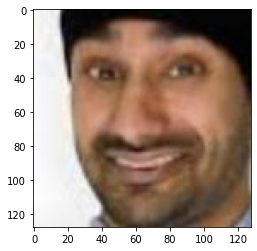

Gender: Male Age: 40 image_size = (128, 128, 3)


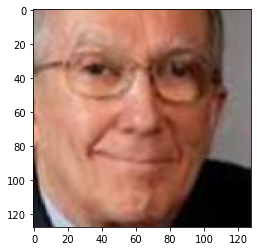

Gender: Male Age: 75 image_size = (128, 128, 3)


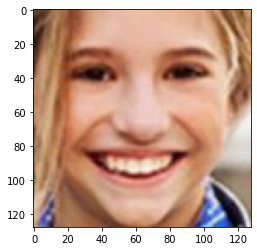

Gender: Female Age: 18 image_size = (128, 128, 3)


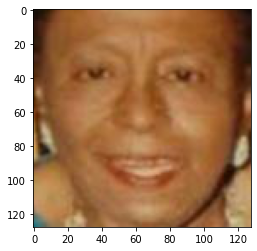

Gender: Female Age: 70 image_size = (128, 128, 3)


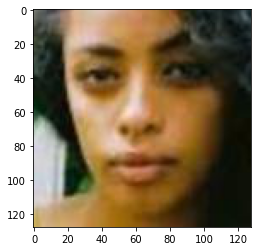

Gender: Female Age: 26 image_size = (128, 128, 3)


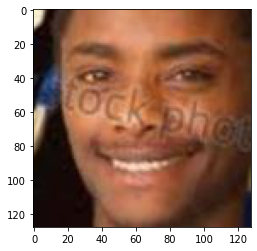

Gender: Male Age: 23 image_size = (128, 128, 3)


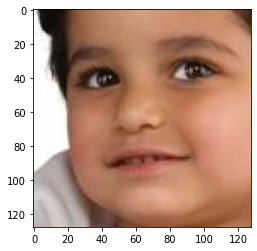

Gender: Male Age: 4 image_size = (128, 128, 3)


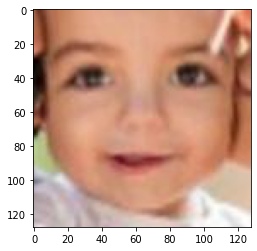

Gender: Female Age: 1 image_size = (128, 128, 3)


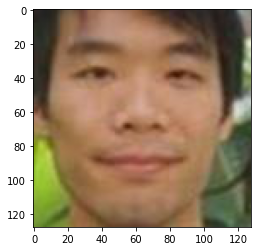

Gender: Male Age: 28 image_size = (128, 128, 3)


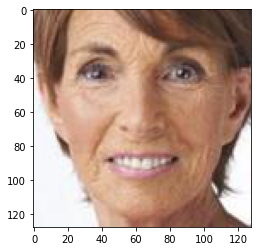

Gender: Female Age: 72 image_size = (128, 128, 3)


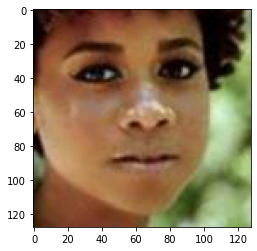

Gender: Female Age: 26 image_size = (128, 128, 3)


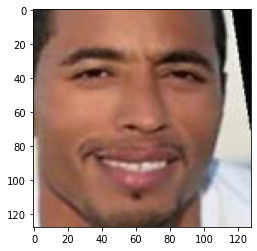

Gender: Male Age: 34 image_size = (128, 128, 3)


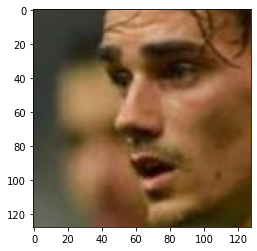

Gender: Male Age: 25 image_size = (128, 128, 3)


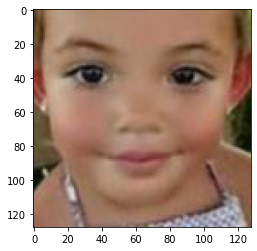

Gender: Female Age: 3 image_size = (128, 128, 3)


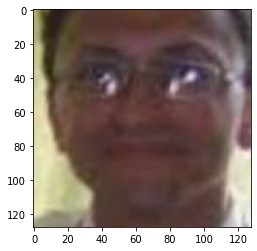

Gender: Male Age: 54 image_size = (128, 128, 3)


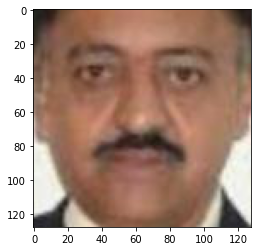

Gender: Male Age: 45 image_size = (128, 128, 3)


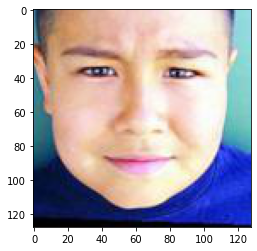

Gender: Male Age: 13 image_size = (128, 128, 3)


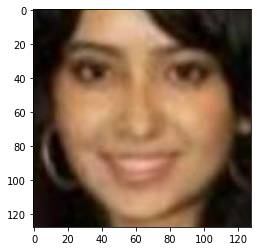

Gender: Female Age: 24 image_size = (128, 128, 3)


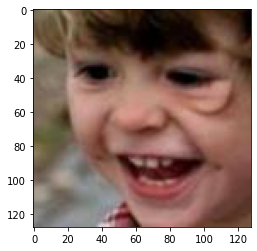

Gender: Male Age: 4 image_size = (128, 128, 3)


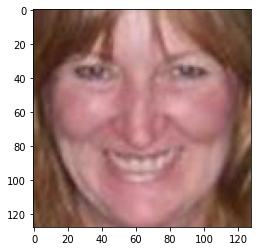

Gender: Female Age: 56 image_size = (128, 128, 3)


In [ ]:
def check_gender(gender):
    if gender == 0:
      return "Male"
    else:
      return "Female"

i = 0
for i in range(20):
  image = images[i] 
  plt.imshow(image)
  plt.show()
  print("Gender:",check_gender(genders[i]),"Age:",ages[i],"image_size =",image.shape)
  i += 1

## Rearrange the dataset
You may do any arrangement for the dataset to suit your later process, such as splitting into training set and validation set, saving the gender labels and age some how, and so on.


In [ ]:
# 80:20 for train:valid dataset
img_features = np.array(images)
img_features = img_features / 255 # normalize images

n_train = int(len(img_features) * 0.80)

X_train, y_train = img_features[:n_train], [np.array(ages[:n_train]), np.array(genders[:n_train])]
x_valid, y_valid = img_features[n_train:], [np.array(ages[n_train:]), np.array(genders[n_train:])]

## STEP1: Data pre-processing
Now you need do some pre-processing before feeding data into a CNN network. You may consider:

1.	Rescale the pixel values (integers between 0 and 255) to [0,1]. **You must do this rescaling.** Otherwise the testing performance will be affected significantly, as the test images will be rescaling in this way. 
2.	Data augmentation.

**Don't rescale the age to [0,1].** Otherwise the testing performance will be affected significantly, as the original age is used in the testing stage. 

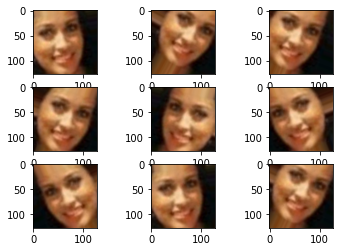

In [ ]:
from numpy import expand_dims
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

def plot_augmentation(img_features):
    data = img_features
    # expand dimension to one sample
    samples = expand_dims(data, 0)
    # create image data augmentation generator
    image_gen = ImageDataGenerator(
            width_shift_range=.10,
            height_shift_range=.10,
            rotation_range=30,
            horizontal_flip=True,
            fill_mode='nearest')
    # prepare iterator
    it = image_gen.flow(samples, batch_size=1)
    # generate samples and plot
    for i in range(9):
        plt.subplot(330 + 1 + i)
        # generate batch of images
        batch = it.next()
        # convert to unsigned integers for viewing
        image = batch[0].astype('uint8')
        plt.imshow(image)
    # show the figure
    plt.show()
    
    
plot_augmentation(images[26])

In [ ]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

batch_size = 64
def generator(X, y_train, batch_size):
    generator = ImageDataGenerator(
            width_shift_range=.10,
            height_shift_range=.10,
            rotation_range=30,
            horizontal_flip=True,
            fill_mode='nearest')

    genX1 = generator.flow(X, y_train[0], batch_size=batch_size, seed = 1)
    genX2 = generator.flow(X, y_train[1], batch_size=batch_size, seed = 1)

    while True:
        X1 = genX1.next()
        X2 = genX2.next()
        yield X1[0], (X1[1], X2[1])

# create generator
gen_flow = generator(X_train, y_train, batch_size = 64)

## STEP2A: Build your own CNN network
Define your own CNN for classifying the gender and predicting the age. Though there are two tasks, you need **only one CNN model, but with two outputs** - you may search online for solution.

There are a few restrictions about your network as follows.
1.	The input size must be 128 x 128 x 3, which means you **should not resize** the original images. This is because my test code relies on this particular input size. Any other size will cause problem in the testing stage.
2.  Please treat the gender classification as a binary problem, i.e., **the output layer for the gender branch has only 1 unit**, instead of 2 (though it is correct to treat the gender classification as a mutli-class problem where class number is 2, the last layer has 2 units). This is because my test code only works for the 1-unit-last-layer gender branch setting. 
3.	The size of feature maps being fed to the first fully connected layer must be less than 10 x 10, while there is no number limitation about the depth.
4.	You may choose any techniques for preventing overfitting. 

In the end of the cell, use `modelA.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 126, 126, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 63, 63, 32)   0           ['conv2d[0][0]']                 
                                                                                              

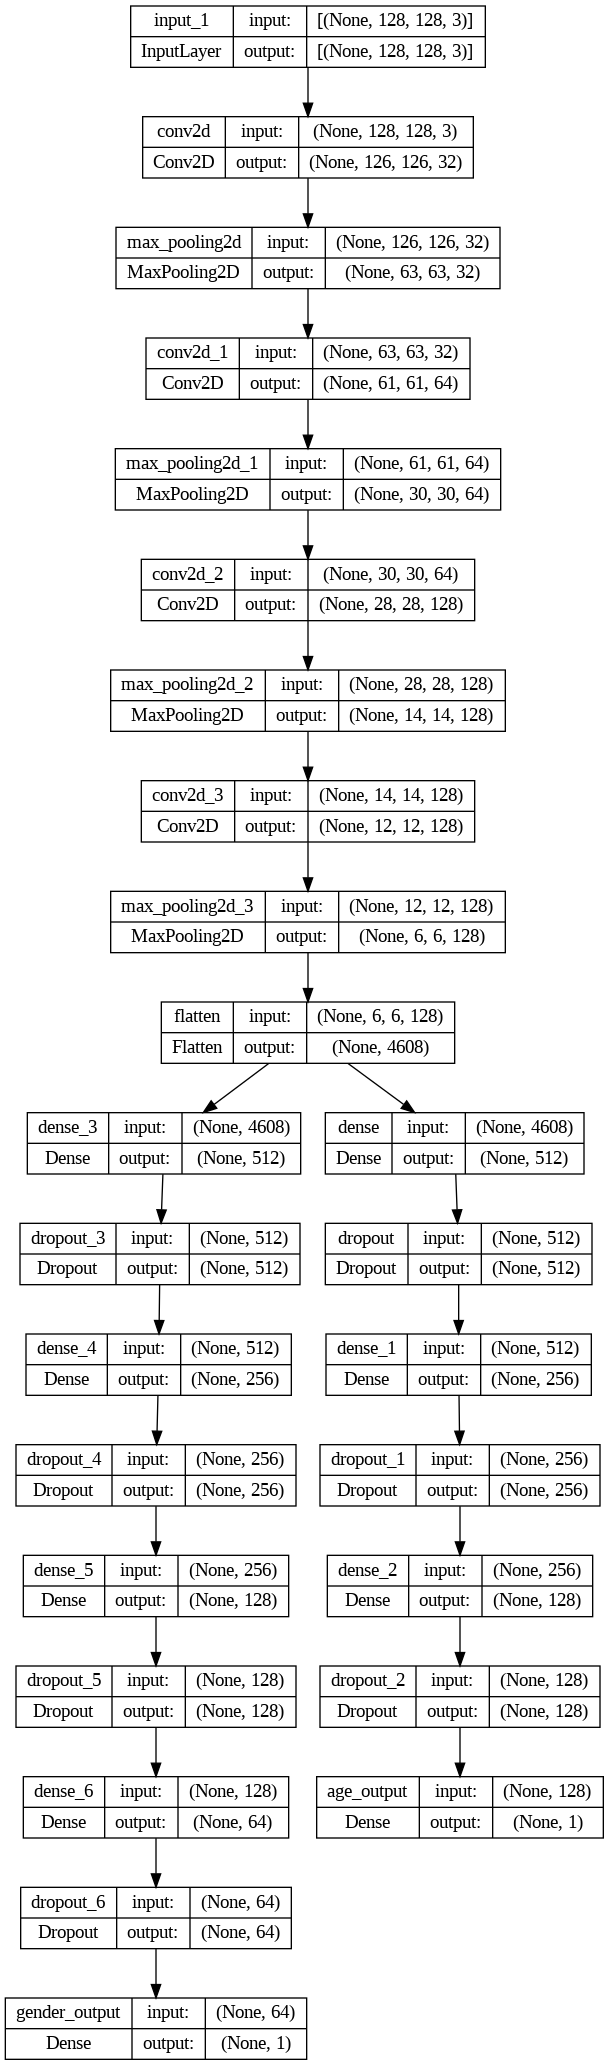

In [ ]:
from keras.models import Model
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate

# Define the input layer
input_layer = Input(shape=(128, 128, 3))

# For CNN: use a simple CNN architecture
x = Conv2D(32, (3, 3), activation='relu')(input_layer)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Flatten()(x)

# Define the age branch
age_branch = Dense(512, activation='relu')(x)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_branch = Dense(256, activation='relu')(age_branch)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_branch = Dense(128, activation='relu')(age_branch)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_output = Dense(1, activation='linear', name='age_output')(age_branch)
# Define the gender branch
gender_branch = Dense(512, activation='relu')(x)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(256, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(128, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(64, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)


# Define the modelA
modelA = Model(inputs=input_layer,
                     outputs = [age_output, gender_output])

# Print the model summary
modelA.summary()

from tensorflow.keras.utils import plot_model
plot_model(modelA, show_shapes=True)

## STEP3A: Compile and train your model
Compile and train your model here. 
Save your model by `modelA.save(your_model_folder+"age_gender_A.h5")` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Save the model with `save()` instead of `save_weights()`.** This is because I will load the model by 

`modelA = load_model(model_folder+"age_gender_A.h5")`. 


In [ ]:
#@title Default title text
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

batch_size = 64
init_lr = 1e-4
epochs = 300

opt = Adam(lr=init_lr)
modelA.compile(optimizer=opt, 
              loss={
                  'age_output': 'mean_absolute_error', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'MAE', 
                  'gender_output': 'accuracy'})
early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = modelA.fit(gen_flow,
                      validation_data=(x_valid, (y_valid[0],y_valid[1])),
                      batch_size=batch_size, 
                      steps_per_epoch=X_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      shuffle=True,
                      workers=4,
                      use_multiprocessing=True,
                      validation_batch_size=batch_size,
                      validation_freq=1,
                      callbacks=[early_stop])

modelA.save("age_gender_A.h5")

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
62/62 [==============================] - 41s 450ms/step - loss: 21.1375 - age_output_loss: 20.4248 - gender_output_loss: 0.7127 - age_output_MAE: 20.4248 - gender_output_accuracy: 0.5151 - val_loss: 16.9927 - val_age_output_loss: 16.2768 - val_gender_output_loss: 0.7159 - val_age_output_MAE: 16.2768 - val_gender_output_accuracy: 0.5200
Epoch 2/300
62/62 [==============================] - 24s 389ms/step - loss: 17.9430 - age_output_loss: 17.2368 - gender_output_loss: 0.7062 - age_output_MAE: 17.2368 - gender_output_accuracy: 0.5033 - val_loss: 16.5814 - val_age_output_loss: 15.8801 - val_gender_output_loss: 0.7014 - val_age_output_MAE: 15.8801 - val_gender_output_accuracy: 0.4970
Epoch 3/300
62/62 [==============================] - 26s 426ms/step - loss: 16.2517 - age_output_loss: 15.5490 - gender_output_loss: 0.7027 - age_output_MAE: 15.5490 - gender_output_accuracy: 0.4932 - val_loss: 16.9955 - val_age_output_loss: 16.2980 - val_gender_output_loss: 0.6975 - val_age_output_

## STEP4A: Draw the learning curves
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set


In [ ]:
#
# Add your code here
#

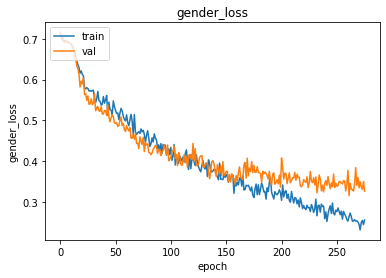

In [ ]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender_loss')
plt.ylabel('gender_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

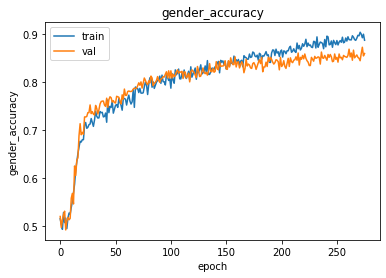

In [ ]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender_accuracy')
plt.ylabel('gender_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

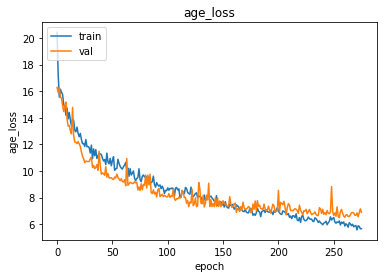

In [ ]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age_loss')
plt.ylabel('age_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

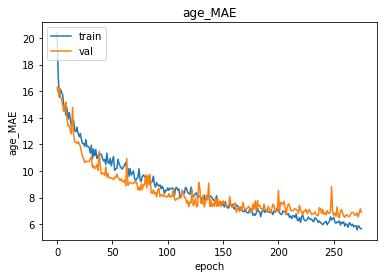

In [ ]:
plt.plot(history.history['age_output_MAE'])
plt.plot(history.history['val_age_output_MAE'])
plt.title('age_MAE')
plt.ylabel('age_MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## STEP2B: Build a CNN network based on a pre-trained model 
Choose one existing CNN architecture pre-trained on ImageNet, and fine-tune on this dataset.

The same as required in Model A, **don’t resize the input image size**. **The output layer for the gender branch is set to have only 1 unit**. 

In the end of the cell, use `modelB.summary()` to output the model architecture. You may also use `plot_model()` to visualize its architecture.


17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_1[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)           

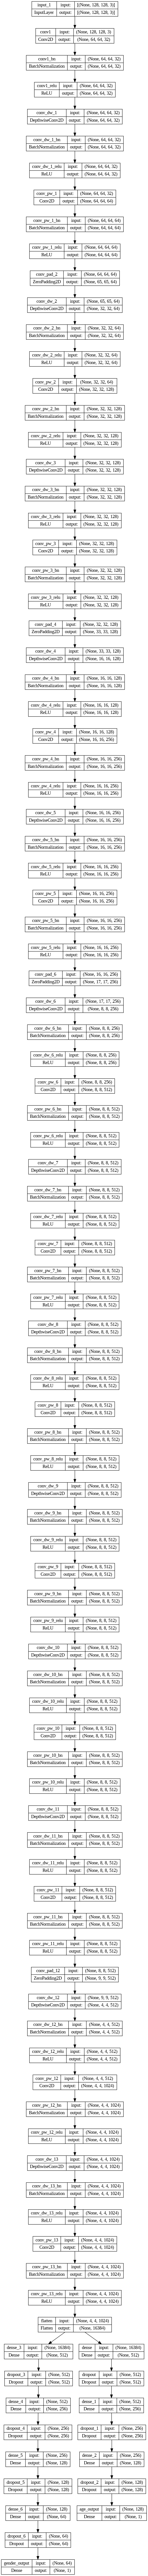

In [ ]:
from keras.models import Model
from keras.layers import Input,Dense, Flatten, Conv2D, MaxPooling2D, Dropout, Concatenate, GlobalAveragePooling2D

#  MobileNet
from tensorflow.keras.applications import MobileNet
mob_model = MobileNet(include_top = False, input_shape = (128 , 128, 3), weights = 'imagenet')
x = Flatten()(mob_model.output)
# x = GlobalAveragePooling2D()(flatten)

# Define the age branch
age_branch = Dense(512, activation='relu')(x)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_branch = Dense(256, activation='relu')(age_branch)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_branch = Dense(128, activation='relu')(age_branch)
age_branch = Dropout(0.2)(age_branch,training=True)  # Add a dropout layer
age_output = Dense(1, activation='linear', name='age_output')(age_branch)

# Define the gender branch
gender_branch = Dense(512, activation='relu')(x)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(256, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(128, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_branch = Dense(64, activation='relu')(gender_branch)
gender_branch = Dropout(0.4)(gender_branch,training=True)  # Add a dropout layer
gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_branch)

modelB = Model(inputs= mob_model.input,
                     outputs = [age_output, gender_output])

modelB.summary()
from tensorflow.keras.utils import plot_model
plot_model(modelB, show_shapes=True)

## STEP3B: Compile and train your model
Compile and train your model here. 
Save your model to `age_gender_B.h5` after training. 

**DON'T use any other name for your model file.** This is because my test code relies on this particular model name. Any other file name will cause problem in the testing stage.

**Also, save the model with `save()` instead of `save_weights()`.** 


In [ ]:
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping

batch_size = 64
init_lr = 1e-4
epochs = 300

opt = Adam(lr=init_lr)
modelB.compile(optimizer=opt, 
              loss={
                  'age_output': 'mean_absolute_error', 
                  'gender_output': 'binary_crossentropy'},
              metrics={
                  'age_output': 'MAE', 
                  'gender_output': 'accuracy'})

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1)

history = modelB.fit(gen_flow,
                      validation_data=(x_valid, (y_valid[0],y_valid[1])),
                      batch_size=batch_size, 
                      steps_per_epoch=X_train.shape[0] // batch_size,
                      epochs=epochs,
                      verbose=1,
                      shuffle=True,
                      workers=4,
                      use_multiprocessing=True,
                      validation_batch_size=batch_size,
                      validation_freq=1,
                      callbacks=[early_stop])

modelB.save("age_gender_B.h5")

/usr/local/lib/python3.9/dist-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/300
62/62 [==============================] - 46s 505ms/step - loss: 13.2920 - age_output_loss: 12.3673 - gender_output_loss: 0.9246 - age_output_MAE: 12.3673 - gender_output_accuracy: 0.5471 - val_loss: 17.7265 - val_age_output_loss: 16.8817 - val_gender_output_loss: 0.8449 - val_age_output_MAE: 16.8817 - val_gender_output_accuracy: 0.5390
Epoch 2/300
62/62 [==============================] - 25s 404ms/step - loss: 9.9121 - age_output_loss: 9.2075 - gender_output_loss: 0.7045 - age_output_MAE: 9.2075 - gender_output_accuracy: 0.6127 - val_loss: 16.6972 - val_age_output_loss: 16.0214 - val_gender_output_loss: 0.6758 - val_age_output_MAE: 16.0214 - val_gender_output_accuracy: 0.5990
Epoch 3/300
62/62 [==============================] - 29s 477ms/step - loss: 9.0342 - age_output_loss: 8.3808 - gender_output_loss: 0.6535 - age_output_MAE: 8.3808 - gender_output_accuracy: 0.6530 - val_loss: 9.1804 - val_age_output_loss: 8.5892 - val_gender_output_loss: 0.5912 - val_age_output_MAE: 8.5

## STEP4B: Draw the learning curve
Draw four figures as follows
1.	The loss of the gender classification over the training and validation set
2.	The accuracy of the gender classification over the training and validation set
3.	The loss of the age estimation over the training and validation set
4.	The MAE of the age estimation over the training and validation set

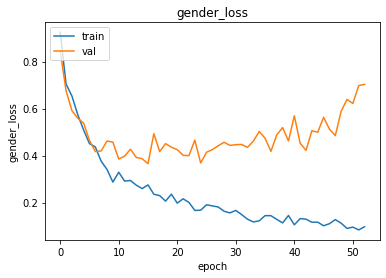

In [ ]:
plt.plot(history.history['gender_output_loss'])
plt.plot(history.history['val_gender_output_loss'])
plt.title('gender_loss')
plt.ylabel('gender_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

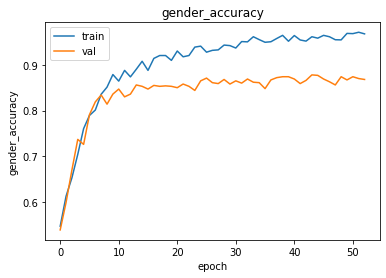

In [ ]:
plt.plot(history.history['gender_output_accuracy'])
plt.plot(history.history['val_gender_output_accuracy'])
plt.title('gender_accuracy')
plt.ylabel('gender_accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

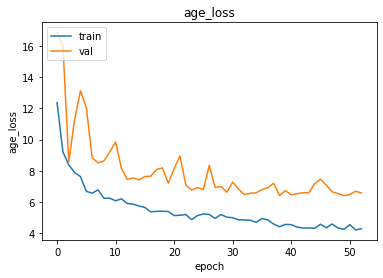

In [ ]:
plt.plot(history.history['age_output_loss'])
plt.plot(history.history['val_age_output_loss'])
plt.title('age_loss')
plt.ylabel('age_loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

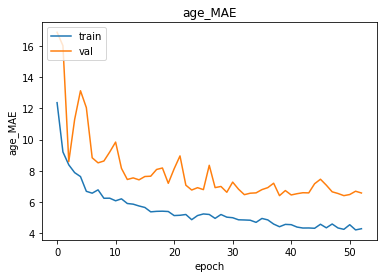

In [ ]:
plt.plot(history.history['age_output_MAE'])
plt.plot(history.history['val_age_output_MAE'])
plt.title('age_MAE')
plt.ylabel('age_MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## STEP5: Evaluate the model on the test set
I will add my test code here to test the two models you trained. The test set will not be available before your submission. 

The metrics for measuring the performance on the test set are:
- age estimation: MAE (Mean Absolute Error)
- gender classification: accuracy


In [ ]:
#
# Don't add code in this cell when submitting this file
#